# Perform a looping with the quadrotor

# Goal of the project

The goal of this project is to control a 2D quadrotor to get it to perform acrobatic moves. The controller will be designed using an SQP solver.

Please submit your code as a runnable Jupyter Notebook.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [60]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2




## Part 1 - Setting up the trajectory Optimization (50 points)
1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)
2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.
3. Show plots of all the states and controls of the robot as a function of time. Describe your design choices (in a concise manner) in the report.

## Part 2 - Model predictive control (MPC) (50 points)
1. Use the trajectory optimization method from Part I to design a MPC controller and test it using the simulator below. In particular, verify that it can handle perturbations by calling the ```quadrotor.simulate``` function with ```disturbance = True``` (when setting disturbance to True, the simulator will generate a random perturbation every 1 second). Simulate your controller for 10 seconds, plot the state anc control evolution.
2. Explain your intended design in the report, including the cost function and found control law

The ```quadrotor.simulate``` function takes as an input an initial state, a controller, the number of discrete time steps and a boolean value to indicate the presence of perturbation. The controller has to be a function taking as an input a state and time index and outputting a control vector.

To visualize the trajectory, use the ```quadrotor.animate_robot``` function
and show the animation (show the plots in your report).

## Bonus (10 points)
Add a state constraint to perform the looping while maintening a positive altitude. Use the origin as an initial state.

In [61]:
import numpy as np
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
from scipy.linalg import block_diag
from scipy.sparse import csr_matrix
import gc
from typing import Tuple, Any





from qpsolvers import Problem, solve_problem
np.set_printoptions(precision=8)

def controller(x, t):
    return np.zeros(2)

x_init = np.array([0, 0, 0., 0 ,0, 0])
horizon_length = 100
t, state, u = quadrotor.simulate(x_init, controller, horizon_length, disturbance=True)
# quadrotor.animate_robot(state, u)


## Solution : Part 1 - Setting up the trajectory Optimization (50 points)
### 1. Discretize the system dynamics using the Euler method seen in class - write the time discretization step as $\Delta t$ (use symbols not numbers for the mass, etc)

To discretise the system dynamics, we shall simply rearrange the given dynamic equations such that multiplication with $\Delta t$ will provide the necessary addition to the current state resulting in the next state. This is shown below - 

$$\begin{align*}
    \dot{p}_{x_n} &= v_{x_n} \\
    \dot{v}_{x_n} &= - \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} \\
    \dot{p}_{y_n} &= v_{y_n} \\
    \dot{v}_{y_n} &= \frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - g \\
    \dot{\theta}_n &= \omega_n \\
    \dot{\omega}_n &= r \frac{(u_{1_n} - u_{2_n})}{I} = \frac{L(u_{1_n} - u_{2_n})}{I}  \quad, \quad L = \text{ Length of quadrotor}
\end{align*}$$

This gives us the equality constraints, 
$$\begin{align*}
    p_{x_{n+1}} &= p_{x_n} + \Delta t v_{x_n} \\
    v_{x_{n+1}} &= v_{x_n} - \Delta t \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} \\
    p_{y_{n+1}} &= p_{y_n} + \Delta t v_{y_n} \\
    v_{y_{n+1}} &= v_{y_n} + \Delta t \left(\frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - g \right)\\
    \theta_{n+1} &= \theta_{n} + \Delta t \omega_n \\
    \omega_{n+1} &= \omega_{n} + \Delta t \frac{L(u_{1_n} - u_{2_n})}{I}
\end{align*}$$

As we can see, a couple of the constraints are non-linear. So we must first find a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ where $\Delta x$ represents a small variation around $\bar{x}$. To do that, we shall perform the Taylor Expansion of the constraints around $\bar{x}$, which will be given by, 

$$\begin{align*}
    \Delta p_{x_{n+1}} &= \Delta p_{x_n} + \Delta t \Delta v_{x_n} \\
    \Delta v_{x_{n+1}} &= \Delta v_{x_n} - \Delta t \Delta \theta_n \frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - \Delta t (\Delta u_{1_n} +  \Delta u_{2_n} )\frac{\sin \theta_n}{m}\\
    \Delta p_{y_{n+1}} &= \Delta p_{y_n} + \Delta t \Delta v_{y_n} \\
    \Delta v_{y_{n+1}} &= \Delta v_{y_n} - \Delta t \Delta \theta_n \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} + \Delta t (\Delta u_{1_n} + \Delta u_{2_n}) \frac{\cos \theta_n}{m}\\
    \Delta \theta_{n+1} &= \Delta \theta_{n} + \Delta t \Delta \omega_n \\
    \Delta \omega_{n+1} &= \Delta \omega_{n} + \Delta t \frac{L(\Delta u_{1_n} - \Delta u_{2_n})}{I}
\end{align*}$$

Finally, we shall put it in the matrix form $Ay = b$ where $A$ would be the Jacobian of the Constraints, $\Delta y$ would be the small variation around the combined state and control vector and $b$ would be tne constraints themselves. 
$\begin{equation}\notag A(y) \Delta y = b(y) \end{equation}$
Where, 
$$
A = \begin{bmatrix} 
    1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & \cdots \\
    0 & 1 & 0 & 0 & -\Delta t \frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} & 0 & -\Delta t \frac{\sin \theta_n}{m} & -\Delta t \frac{\sin \theta_n}{m} & 0 & -1 & 0 & 0 & 0 & 0 & \cdots \\ 
    0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 & 0 & \cdots \\
    0 & 0 & 0 & 1 & -\Delta t \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} & 0 & \Delta t \frac{\cos \theta_n}{m} & \Delta t \frac{\cos \theta_n}{m} & 0  & 0  & 0  & -1  & 0  & 0 & \cdots \\ 
    0 & 0 & 0 & 0 & 1 & \Delta t & 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 & \cdots \\ 
    0 & 0 & 0 & 0 & 0 & 1 & \Delta t \frac{L}{I} & -\Delta t \frac{L}{I} & 0 &  0 &  0 &  0 &  0 &  -1 & \cdots \\ 
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{bmatrix} 
$$

$$
\Delta y = \begin{bmatrix} \Delta X_0 \\ \Delta U_0 \\ \Delta X_1 \\ \Delta U_1 \\ \vdots \end{bmatrix}
\quad 
b = \begin{bmatrix} 
    X_{init} - X_0 \\ 
    p_{x_n} + \Delta t \cdot v_{x_n} -  p_{x_{n+1}} \\ 
    v_{x_n} - \Delta t \frac{(u_{1_n} + u_{2_n}) \sin \theta_n}{m} - v_{x_{n+1}} \\ 
    p_{y_n} + \Delta t \cdot v_{y_n} - p_{y_{n+1}} \\ 
    v_{y_n} + \Delta t \left(\frac{(u_{1_n} + u_{2_n}) \cos \theta_n}{m} - g \right) - v_{y_{n+1}} \\ 
    \theta_{n} + \Delta t \cdot \omega_n - \theta_{n+1} \\ 
    \omega_{n} + \Delta t \frac{L(u_{1_n} - u_{2_n})}{I} - \omega_{n+1} \\ 
    \vdots 
\end{bmatrix}
$$


Here, $X_{init}$ is the initial state of the quadrotor. As it is not defined in the constraints and can change for MPC, we must provide the functionality for it to be variable.

Based on this logic, we shall write a function to compute $A$ and $b$, as shown below.

In [62]:
def compute_A_b(x_init: np.ndarray, y: np.ndarray, N: int = 500) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the matrices `A` and `b` representing the equality constraints for 
    the quadrotor dynamics in a discretized optimization framework.

    Parameters:
    ----------
    x_init : np.ndarray
        Initial state of the quadrotor, a 1D array of size `DIM_STATE` or 2D array of shape `(DIM_STATE, 1)`.
    y : np.ndarray
        Concatenated vector of state and control variables over the trajectory, 
        a 1D array of size `(N * (DIM_STATE + DIM_CONTROL))`.
    N : int, optional
        Number of time steps in the trajectory. Default is 500.

    Returns:
    -------
    A : np.ndarray
        Matrix of size `(6 * N, N * (DIM_STATE + DIM_CONTROL))` defining the coefficients of the equality constraints.
    b : np.ndarray
        Vector of size `(6 * N,)` representing the constant terms of the equality constraints.

    Raises:
    ------
    ValueError
        If the shape of `y` or `x_init` does not match the expected dimensions.

    Notes:
    ------
    - This function assumes that the quadrotor dynamics follow a specific structure, including constraints for 
      position, velocity, orientation, and angular velocity.
    - The matrices `A` and `b` are populated using the quadrotor dynamics equations, 
      discretized over a given time step `DT`.
    """

    # Total dimension of state and control per time step
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

    # Convert inputs to NumPy arrays if they aren't already
    y = np.asarray(y, dtype=np.float64)
    x_init = np.asarray(x_init, dtype=np.float64)

    # Expected shapes based on the trajectory
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)
    expected_x_init_shape = (quadrotor.DIM_STATE,)
    expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)

    # Validate the input dimensions
    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")
    if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
        raise ValueError(
            f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

    # Flatten inputs if they are in 2D
    if y.shape == expected_y_shape_alt:
        y = y.flatten()
    if x_init.shape == expected_x_init_shape_alt:
        x_init = x_init.flatten()

    # Number of constraints (6 per time step)
    num_constraints = 6 * N
    # Constraint coefficient matrix
    A = np.zeros((num_constraints, y_i_dim * N))
    b = np.zeros(num_constraints)  # Constraint constant terms

    # Initial condition constraints
    A[:6, :] = np.eye(6, y_i_dim * N)
    b[:6] = x_init - y[:6]

    # Populate constraints for each time step
    for n in range(0, N - 1):
        i = n * y_i_dim  # Starting index for time step n
        idx_n = i
        idx_n1 = i + y_i_dim  # Starting index for time step n+1

        # Extract state and control variables at time step n
        px, vx, py, vy, theta, omega, u1, u2 = y[idx_n:idx_n + 8]

        # Extract state variables at time step n+1
        px_next, vx_next, py_next, vy_next, theta_next, omega_next = y[idx_n1:idx_n1 + 6]

        # Row index for constraints at this time step
        row = (n + 1) * 6

        # Position constraints
        A[row, idx_n] = 1  # px_n
        A[row, idx_n + 1] = quadrotor.DT  # vx_n
        A[row, idx_n1] = -1  # px_{n+1}
        b[row] = px + quadrotor.DT * vx - px_next

        A[row + 2, idx_n + 2] = 1  # py_n
        A[row + 2, idx_n + 3] = quadrotor.DT  # vy_n
        A[row + 2, idx_n1 + 2] = -1  # py_{n+1}
        b[row + 2] = py + quadrotor.DT * vy - py_next

        # Velocity constraints
        A[row + 1, idx_n + 1] = 1  # vx_n
        A[row + 1, idx_n + 4] = -quadrotor.DT * \
            ((u1 + u2) * np.cos(theta) / quadrotor.MASS)  # θ_n
        A[row + 1, idx_n + 6:idx_n + 8] = -quadrotor.DT * \
            (np.sin(theta) / quadrotor.MASS)  # u1_n, u2_n
        A[row + 1, idx_n1 + 1] = -1  # vx_{n+1}
        b[row + 1] = vx - quadrotor.DT * \
            (u1 + u2) * np.sin(theta) / quadrotor.MASS - vx_next

        A[row + 3, idx_n + 3] = 1  # vy_n
        A[row + 3, idx_n + 4] = -quadrotor.DT * \
            ((u1 + u2) * np.sin(theta) / quadrotor.MASS)  # θ_n
        A[row + 3, idx_n + 6:idx_n + 8] = quadrotor.DT * \
            (np.cos(theta) / quadrotor.MASS)  # u1_n, u2_n
        A[row + 3, idx_n1 + 3] = -1  # vy_{n+1}
        b[row + 3] = vy + quadrotor.DT * \
            (((u1 + u2) * np.cos(theta) / quadrotor.MASS) -
             quadrotor.GRAVITY_CONSTANT) - vy_next

        # Orientation constraints
        A[row + 4, idx_n + 4] = 1  # θ_n
        A[row + 4, idx_n + 5] = quadrotor.DT  # ω_n
        A[row + 4, idx_n1 + 4] = -1  # θ_{n+1}
        b[row + 4] = theta + quadrotor.DT * omega - theta_next

        # Angular velocity constraints
        A[row + 5, idx_n + 5] = 1  # ω_n
        A[row + 5, idx_n + 6] = quadrotor.DT * \
            (quadrotor.LENGTH / quadrotor.INERTIA)  # u1_n
        A[row + 5, idx_n + 7] = -quadrotor.DT * \
            (quadrotor.LENGTH / quadrotor.INERTIA)  # u2_n
        A[row + 5, idx_n1 + 5] = -1  # ω_{n+1}
        b[row + 5] = omega + quadrotor.DT * quadrotor.LENGTH * \
            (u1 - u2) / quadrotor.INERTIA - omega_next

    return A, b

### 2. We would like the quadrotor to perfom a looping. Find and implement a suitable cost function to perform a looping and add constraint to maintain the thrust of each rotor between $0$ and $10$. Solve the problem using your own implementation of a SQP (levarging your code from Homework 2) with a large horizon to check that you can do a looping.

#### 2.1 Loop Definition
Firstly, let us define a loop. For the purpose of simplicity, we shall choose four waypoints in the shape of an improper rhombus that define the loop. Also, we shall set the desired angle $\theta$ at each of these waypoints, such that the drone flips at the peak of the loop. Parametrically,  
$$loop(\theta_k) = \frac{k}{100} \cdot 2\pi$$
            
$$
loop(p_x, p_y) =
\begin{cases}
    (0, 0), & \text{if } k < 20, \\
    (1, 3), & \text{if } 20 \leq k < 40, \\
    (0, 3), & \text{if } 40 \leq k < 60, \\
    (-1, 3), & \text{if } 60 \leq k < 80, \\
    (0, 0), & \text{if } 80 \leq k \leq 100.
\end{cases}
$$

Where $k$ is the time step and a single loop will take 100 timesteps. Thus, in this way we have a defined point along the trajectory for each time step. Using this logic, the below function has been formulated.


In [63]:
def find_xk_yk_thetak(k: int, N_WAVE: int = 100, MAX_Y: int = 3, MAX_X: int = 1) -> Tuple[float, float, float]:
    """
    Determines the position (x_k, y_k) and orientation (theta_k) of the quadrotor 
    at a given discrete time step `k` for a looping trajectory.

    Parameters:
    ----------
    k : int
        The current discrete time step for which the state is computed.
    N_WAVE : int, optional
        The total number of discrete steps in one complete loop of the trajectory.
        Must be a multiple of 100. Default is 100.
    MAX_Y : int, optional
        Maximum vertical position (amplitude) of the trajectory. Default is 3.
    MAX_X : int, optional
        Maximum horizontal position (amplitude) of the trajectory. Default is 1.

    Returns:
    -------
    Tuple[float, float, float]
        A tuple containing:
        - x_k (float): The x-coordinate of the quadrotor at time step `k`.
        - y_k (float): The y-coordinate of the quadrotor at time step `k`.
        - theta_k (float): The orientation angle (in radians) of the quadrotor at time step `k`.

    Raises:
    ------
    ValueError
        If `N_WAVE` is not a multiple of 100.

    Notes:
    ------
    - The trajectory is divided into 5 segments based on `N_WAVE`, with specific 
      positions and orientations for each segment.
    - The orientation `theta_k` progresses linearly from 0 to \(2\pi\) over 100 steps 
      and repeats cyclically for larger values of `k`.
    """
    # Validate that the wavelength N_WAVE is a multiple of 100
    if N_WAVE % 100 != 0:
        raise ValueError(
            f'For the Wavelength N_WAVE = {N_WAVE}, IT IS NOT A MULTIPLE OF 100.')

    # Initialize position and orientation
    x_k: float = 0.0
    y_k: float = 0.0
    # Orientation cycles every 100 steps
    theta_k: float = (k / 100) * (2 * np.pi)

    # Map k to its position within the current wavelength cycle
    k = k % N_WAVE

    # Determine the position (x_k, y_k) based on the current segment
    if k < (N_WAVE / 5):  # Segment 1: Start position
        x_k = 0.0
        y_k = 0.0
    elif (N_WAVE / 5) <= k < (2 * N_WAVE / 5):  # Segment 2: Ascent to top-right corner
        x_k = float(MAX_X)
        y_k = float(MAX_X)
    elif (2 * N_WAVE / 5) <= k < (3 * N_WAVE / 5):  # Segment 3: Top of the loop
        x_k = 0.0
        y_k = float(MAX_Y)
    elif (3 * N_WAVE / 5) <= k < (4 * N_WAVE / 5):  # Segment 4: Descent to top-left corner
        x_k = -float(MAX_X)
        y_k = float(MAX_X)
    elif (4 * N_WAVE / 5) <= k <= N_WAVE:  # Segment 5: Return to start
        x_k = 0.0
        y_k = 0.0

    return x_k, y_k, theta_k



#### 2.2 Cost Function Formulation 

The above equations essentially give us a trajectory that needs to be followed at any given time or iteration. Using this, we can easily formulate the cost to be, 
$$\frac{1}{2}\left(\sum_{k=0}^{N-1} (X_k - X_{k_des})^T Q (X_k - X_{k_des}) + U_n^T R U_n + (X_N - X_{N_des})^T Q (X_N - X_{N_des})\right)$$
Which penalizes deviation of the state from the desired state. This is equivalent to minimizing this cost (expanding and then ignoring constant terms, i.e. terms that do not depend on $X_n$)

$$\sum_{k=0}^{N-1} \left(\frac{1}{2}X_k^T Q X_k + \frac{1}{2}U_n^T R U_n - X_{k_des}^T Q X_k \right) + \frac{1}{2}X_k^T Q X_k + X_{N_des}^T Q X_N$$

Where, 
$$X_{k_des}^T = \begin{bmatrix}loop(p_x) & 0 &  loop(p_y)  & 0 & loop(\theta) & 0 \end{bmatrix}$$

The goal is to minimise this cost function, so we get, 

$$\min_{X_k, U_k}\frac{1}{2}\left(\sum_{k=0}^{N-1} X_k^T Q X_k + U_n^T R U_n - 2X_{k_des}^T Q X_k \right) + \frac{1}{2}X_k^T Q X_k + X_{N_des}^T Q X_N$$

Now, let us put it in the matrix form, 
$$\min_y \frac{1}{2} y^T P y + q^T y$$

Where, 
$$\begin{align}
    \notag &y = \begin{bmatrix} X_0 \\ U_0 \\ X_1 \\ U_1 \\ \vdots\end{bmatrix} && P = \begin{bmatrix} Q & 0 & 0 & 0 & \cdots\\ 0 & R & 0 & 0 & \cdots \\ 0 & 0 & Q & 0 & \cdots \\ 0 & 0 & 0 & R & \cdots \\ \vdots & \vdots & \vdots & \vdots & \ddots \end{bmatrix} &&& q^T = \begin{bmatrix} -X_{0_des}^T Q  & 0 & -X_{1_des}^T Q & 0 & \cdots\end{bmatrix}
\end{align}
$$

Note that, we only want to penalise the position, so we shall choose the diagonal elements of $Q$ in such a way that the other elements of the state are not penalised. So, initially, we can set $Q$ and $R$ as below and tune it later. 
$\begin{equation}\notag Q_{diagonal} = \begin{bmatrix} 1 & 0 & 1 & 0 & 0 & 0 \end{bmatrix} \quad R_{diagonal} = \begin{bmatrix} 1 & 1 \end{bmatrix}\end{equation}$

Based on this, we shall write a function to compute the cost, as shown below. 

In [64]:
def cost_func(y: np.ndarray, Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500, k_init: int = 0) -> np.ndarray:
    """
    Computes the cost function value for a given trajectory and control input vector `y`,
    using the specified state and control weighting matrices.

    Parameters:
    ----------
    y : np.ndarray
        The concatenated state and control vector for all time steps. 
        Shape: `(N * (DIM_STATE + DIM_CONTROL),)` or `(N * (DIM_STATE + DIM_CONTROL), 1)`.
    Q_diag : np.ndarray
        Diagonal elements of the state weighting matrix `Q`. Shape: `(DIM_STATE,)`.
    R_diag : np.ndarray
        Diagonal elements of the control weighting matrix `R`. Shape: `(DIM_CONTROL,)`.
    N : int, optional
        Number of time steps in the trajectory. Default is 500.
    k_init : int, optional
        Initial time step index for computing the desired trajectory. Default is 0.

    Returns:
    -------
    float
        The scalar value of the computed cost function.

    Raises:
    ------
    ValueError
        If the shapes of `y`, `Q_diag`, or `R_diag` do not match the expected dimensions.

    Notes:
    ------
    - The cost function is defined as:
      \[
      J(y) = \frac{1}{2} y^T P y + q^T y
      \]
      where:
      - \(P\) is the block-diagonal matrix constructed from `Q` (state weights) and `R` (control weights).
      - \(q\) encodes the linear component derived from the desired trajectory.
    - The desired trajectory \((x_k, y_k, \theta_k)\) is computed using `find_xk_yk_thetak`.

    """
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

    # Ensure inputs are NumPy arrays
    y = np.asarray(y, dtype=np.float64)
    Q_diag = np.asarray(Q_diag, dtype=np.float64)
    R_diag = np.asarray(R_diag, dtype=np.float64)

    # Validate the shape of `y`
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

    # Validate the shape of Q_diag and R_diag
    if Q_diag.shape != (quadrotor.DIM_STATE,):
        raise ValueError(
            f"Input Q_diag must be of shape {(quadrotor.DIM_STATE,)}, but got shape {Q_diag.shape}")
    if R_diag.shape != (quadrotor.DIM_CONTROL,):
        raise ValueError(
            f"Input R_diag must be of shape {(quadrotor.DIM_CONTROL,)}, but got shape {R_diag.shape}")

    # Flatten `y` if necessary
    if y.shape == expected_y_shape_alt:
        y = y.flatten()

    # Create block-diagonal matrices for weights
    Q = np.diag(Q_diag)  # State weighting matrix
    R = np.diag(R_diag)  # Control weighting matrix
    # Block diagonal matrix combining Q and R
    P = block_diag(*([block_diag(Q, R)] * N))

    # Initialize the linear term vector `q`
    q = np.zeros((y_i_dim * N))
    for k in range(N):
        # Compute the desired state at time step `k`
        x_k, y_k, theta_k = find_xk_yk_thetak(
            k=k_init, N_WAVE=100, MAX_Y=3, MAX_X=1)
        k_init += 1

        # Construct the corresponding linear term for the cost function
        desired_state = np.array([[x_k], [0], [y_k], [0], [theta_k], [0]])
        q[(k * y_i_dim):(k * y_i_dim) + y_i_dim] = np.concatenate(
            ((-(desired_state.T @ Q)).flatten(), [0., 0.]))  # Append zeros for control terms

    # Reshape `q` for consistency
    q = q.reshape(-1, 1)

    # Compute the cost function value
    cost = ((0.5 * (y.T @ P @ y)) + ((2 * q.T) @ y))[0]
    return cost


#### 2.3 Gradient and Hessian of the cost function 

Let us recall that in lecture 2, a shortcut method was taught to find the gradient of a function. If a function is of the form, 
$\begin{align}
    \notag f(x) &= x^T P x + q^T x \\
    \notag \Rightarrow \nabla f(x) &= 2Px + q \\
    \notag \text{and} \quad \nabla ^2 f(x) &= 2 P
\end{align}$

Based on this logic, we shall write a function to compute the gradient of the cost, as shown below, 

In [65]:
def cost_grad(y: np.ndarray, Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500, k_init: int = 0) -> np.ndarray:
    """
    Computes the gradient of the cost function with respect to the trajectory 
    and control input vector `y`.

    Parameters:
    ----------
    y : np.ndarray
        The concatenated state and control vector for all time steps. 
        Shape: `(N * (DIM_STATE + DIM_CONTROL),)` or `(N * (DIM_STATE + DIM_CONTROL), 1)`.
    Q_diag : np.ndarray
        Diagonal elements of the state weighting matrix `Q`. Shape: `(DIM_STATE,)`.
    R_diag : np.ndarray
        Diagonal elements of the control weighting matrix `R`. Shape: `(DIM_CONTROL,)`.
    N : int, optional
        Number of time steps in the trajectory. Default is 500.
    k_init : int, optional
        Initial time step index for computing the desired trajectory. Default is 0.

    Returns:
    -------
    np.ndarray
        The gradient of the cost function with respect to `y`. Shape: `(N * (DIM_STATE + DIM_CONTROL),)`.

    Raises:
    ------
    ValueError
        If the shapes of `y`, `Q_diag`, or `R_diag` do not match the expected dimensions.

    Notes:
    ------
    - The cost gradient is computed as:
      \[
      \nabla J(y) = P y + q
      \]
      where:
      - \(P\) is the block-diagonal matrix constructed from `Q` (state weights) and `R` (control weights).
      - \(q\) encodes the linear component derived from the desired trajectory.
    - The desired trajectory \((x_k, y_k, \theta_k)\) is computed using `find_xk_yk_thetak`.

    """
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

    # Ensure inputs are NumPy arrays
    y = np.asarray(y, dtype=np.float64)
    Q_diag = np.asarray(Q_diag, dtype=np.float64)
    R_diag = np.asarray(R_diag, dtype=np.float64)

    # Validate the shape of `y`
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

    # Validate the shape of Q_diag and R_diag
    if Q_diag.shape != (quadrotor.DIM_STATE,):
        raise ValueError(
            f"Input Q_diag must be of shape {(quadrotor.DIM_STATE,)}, but got shape {Q_diag.shape}")
    if R_diag.shape != (quadrotor.DIM_CONTROL,):
        raise ValueError(
            f"Input R_diag must be of shape {(quadrotor.DIM_CONTROL,)}, but got shape {R_diag.shape}")

    # Flatten `y` if necessary
    if y.shape == expected_y_shape_alt:
        y = y.flatten()

    # Create block-diagonal matrices for weights
    Q = np.diag(Q_diag)  # State weighting matrix
    R = np.diag(R_diag)  # Control weighting matrix
    # Block diagonal matrix combining Q and R
    P = block_diag(*([block_diag(Q, R)] * N))

    # Initialize the linear term vector `q`
    q = np.zeros((y_i_dim * N))
    for k in range(N):
        # Compute the desired state at time step `k`
        x_k, y_k, theta_k = find_xk_yk_thetak(
            k=k_init, N_WAVE=100, MAX_Y=3, MAX_X=1)
        k_init += 1

        # Construct the corresponding linear term for the cost gradient
        desired_state = np.array([[x_k], [0], [y_k], [0], [theta_k], [0]])
        q[(k * y_i_dim):(k * y_i_dim) + y_i_dim] = np.concatenate(
            ((-(desired_state.T @ Q)).flatten(), [0., 0.]))  # Append zeros for control terms

    # Compute the gradient of the cost function
    gradient = (P @ y) + q
    return gradient

Using the same shortcut, the below function has been formulated to compute the hessian of the cost function

In [66]:
def cost_hess(Q_diag: np.ndarray, R_diag: np.ndarray, N: int = 500) -> np.ndarray:
    """
    Computes the Hessian matrix of the cost function for a given trajectory 
    and control input weighting.

    Parameters:
    ----------
    Q_diag : np.ndarray
        Diagonal elements of the state weighting matrix `Q`. Shape: `(DIM_STATE,)`.
    R_diag : np.ndarray
        Diagonal elements of the control weighting matrix `R`. Shape: `(DIM_CONTROL,)`.
    N : int, optional
        Number of time steps in the trajectory. Default is 500.

    Returns:
    -------
    np.ndarray
        The Hessian matrix of the cost function. Shape: `(N * (DIM_STATE + DIM_CONTROL), N * (DIM_STATE + DIM_CONTROL))`.

    Raises:
    ------
    ValueError
        If the shapes of `Q_diag` or `R_diag` do not match the expected dimensions.

    Notes:
    ------
    - The Hessian of the cost function is a block-diagonal matrix constructed from 
      the state weighting matrix `Q` and control weighting matrix `R` for each time step.
    - This matrix is constant for a given set of `Q_diag` and `R_diag`.
    """
    # Convert inputs to NumPy arrays for consistency
    Q_diag = np.asarray(Q_diag, dtype=np.float64)
    R_diag = np.asarray(R_diag, dtype=np.float64)

    # Validate the shapes of Q_diag and R_diag
    if Q_diag.shape != (quadrotor.DIM_STATE,):
        raise ValueError(
            f"Input Q_diag must be of shape {(quadrotor.DIM_STATE,)}, but got shape {Q_diag.shape}")
    if R_diag.shape != (quadrotor.DIM_CONTROL,):
        raise ValueError(
            f"Input R_diag must be of shape {(quadrotor.DIM_CONTROL,)}, but got shape {R_diag.shape}")

    # Construct diagonal matrices Q and R from their diagonal elements
    Q = np.diag(Q_diag)  # State weighting matrix
    R = np.diag(R_diag)  # Control weighting matrix

    # Construct the block-diagonal Hessian matrix
    hessian = block_diag(*([block_diag(Q, R)] * N))
    return hessian


#### 2.4 Optimal Control Problem Formulation
Now that we have a cost function, all we have to do is formulate the optimal control problem - 
$$\min_{X_k, U_k}\frac{1}{2}\left(\sum_{k=0}^{N-1} X_k^T Q X_k + U_n^T R U_n - X_{k_des}^T Q X_k \right) + \frac{1}{2}X_k^T Q X_k + X_{N_des}^T Q X_N\\
\text{Subject to}\quad X_{n+1} = X_n + \Delta t  f(X_n, U_n)\\ X_0 = X_{init}$$

#### 2.5 Including the Inequality Constraints
It is given that the thrust of the rotors has to be between $0$ and $10$. Mathematically, 
$$ 0 \leq U_n \leq 10$$

Rewriting this in the matrix form of $G y \leq h$, we get, 
$$ 
\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1  \end{bmatrix}
\begin{bmatrix} p_x \\ v_x \\ p_y \\ v_y \\ \theta \\ \omega \\ u_1 \\ u_2 \end{bmatrix} = 
\begin{bmatrix} 10 \\ 0 \\ 10 \\ 0 \end{bmatrix}
$$

We shall appply the same logic as before the linearise the equation $w.r.t ~ \Delta y$ to get $G(y) \Delta y \leq h(y)$

$$ 
\begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1  \end{bmatrix}
\begin{bmatrix} \Delta p_x \\ \Delta v_x \\ \Delta p_y \\ \Delta v_y \\ \Delta \theta \\ \Delta \omega \\ \Delta u_1 \\ \Delta u_2 \end{bmatrix} = 
\begin{bmatrix} 10 - u_1 \\ u_1 \\ 10 - u_2 \\ u_2 \end{bmatrix}
$$

##### 2.5.1 BONUS - Positive Altitude
"Positive Altitude" mathematically implies, 
$$p_y \geq 0$$

Upon including this constraint as well, we can formulate the linearized inequalities to be, 
$$G(y) \Delta y \leq h(y)$$

Where, 
$$
G =\begin{bmatrix}0 & 0 & -1 & 0 & 0 & 0 & 0 & 0 & \cdots\\ 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0  & \cdots\\ 0 & 0 & 0 & 0 & 0 & 0 & -1 & 0  & \cdots\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1  & \cdots\\ 0 & 0 & 0 & 0 & 0 & 0 & 0 & -1 & \cdots \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots \end{bmatrix} \quad h = \begin{bmatrix} \bar{p}_{y_0} \\ 10 - \bar{u}_{1_0} \\ \bar{u}_{1_0} \\ 10 - \bar{u}_{2_0} \\ \bar{u}_{2_0} \\ \vdots\end{bmatrix}
$$

Based on this logic, the below function has been formulated.

In [67]:
def compute_G_h(y: np.ndarray, N: int = 500) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the inequality constraint matrix `G` and vector `h` for the optimization problem.

    Parameters:
    ----------
    y : np.ndarray
        The concatenated state and control vector for all time steps.
        Shape: `(N * (DIM_STATE + DIM_CONTROL),)` or `(N * (DIM_STATE + DIM_CONTROL), 1)`.
    N : int, optional
        Number of time steps in the trajectory. Default is 500.

    Returns:
    -------
    tuple:
        G : np.ndarray
            Inequality constraint matrix of shape `((DIM_CONTROL + 1) * 2 * N, N * (DIM_STATE + DIM_CONTROL))`.
        h : np.ndarray
            Inequality constraint vector of shape `((DIM_CONTROL + 1) * 2 * N,)`.

    Raises:
    ------
    ValueError
        If the shape of `y` does not match the expected dimensions.

    Notes:
    ------
    - The inequality constraints enforce:
      1. \( p_y \geq 0 \) (non-negative altitude).
      2. \( 0 \leq u_1 \leq 10 \) and \( 0 \leq u_2 \leq 10 \) (control input limits).
    - The matrix `G` and vector `h` are constructed to represent:
      \[
      G y \leq h
      \]
      where each row corresponds to an inequality constraint for a specific time step.
    """
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

    # Convert inputs to NumPy arrays for consistency
    y = np.asarray(y, dtype=np.float64)

    # Validate the shape of `y`
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

    # Flatten `y` if necessary
    if y.shape == expected_y_shape_alt:
        y = y.flatten()

    # Define the per-step inequality constraint matrix
    G_i = np.array([
        [0, 0, 0, 0, 0, 0, 0, 0],  # Placeholder for altitude (p_y >= 0)
        [0, 0, -1, 0, 0, 0, 0, 0],  # p_y constraint
        [0, 0, 0, 0, 0, 0, 1, 0],  # u_1 <= 10
        [0, 0, 0, 0, 0, 0, -1, 0],  # u_1 >= 0
        [0, 0, 0, 0, 0, 0, 0, 1],  # u_2 <= 10
        [0, 0, 0, 0, 0, 0, 0, -1]   # u_2 >= 0
    ])

    # Construct the block-diagonal matrix G
    G = block_diag(*([G_i] * N))

    # Initialize the inequality vector `h`
    h = np.zeros(((((quadrotor.DIM_CONTROL + 1) * 2) * N),), dtype=np.float64)

    # Populate `h` with the inequality limits for each time step
    for i in range(N):
        # Extract control inputs at time step `i`
        u_1 = y[(i * y_i_dim) + 6]
        u_2 = y[(i * y_i_dim) + 7]

        # Populate `h` for the current time step
        h[((i * (quadrotor.DIM_CONTROL + 1) * 2))] = 0  # p_y >= 0
        h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 1)
          ] = y[(i * y_i_dim) + 2]  # p_y constraint
        h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 2)] = 10 - u_1  # u_1 <= 10
        h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 3)] = u_1  # u_1 >= 0
        h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 4)] = 10 - u_2  # u_2 <= 10
        h[((i * (quadrotor.DIM_CONTROL + 1) * 2) + 5)] = u_2  # u_2 >= 0

    return G, h

#### 2.5 Formulating the KKT Conditions

Now that we have all the prerequsities, our KKT can be forumalted as below, 
$$\begin{equation}
\begin{aligned}
    \min_{p} \quad &P^T \nabla_{yy}^2 \mathcal{L}(y_k) P + q^T \nabla f(y_k) \\
    \text{subject to} \quad & \nabla g(y_k)^T P + g(y_k) = 0 \\
    & \nabla h(y_k)^T P + h(y_k) \leq 0
\end{aligned}
\end{equation}$$ 

Which is the same as solving

$$\begin{equation}\notag 
    \begin{bmatrix} 
        \nabla^2_{yy} \mathcal{L}(y_k) & \nabla g(y_k) ^T  & \nabla h(y_k)^T \\
        \nabla g(y_k) & 0 & 0 \\
        \nabla h(y_k) & 0 & 0
    \end{bmatrix}
    \begin{pmatrix} 
        p_k \\ 
        \lambda_{k+1} \\
        \mu_{k+1} 
    \end{pmatrix} 
    = 
    \begin{pmatrix} 
        -\nabla f(y_k) \\ 
        -g(y_k) \\
        - h(y_k)
    \end{pmatrix}
\end{equation}$$

Associating the elements of the KKT with our variables, we have - 

|KKT Matrix Element| Chosen Variable Or Function|
|---|--- |
| $\nabla^2_{yy} \mathcal{L}(y_k)$|cost_hess()|
|$\nabla f(y_k)$| cost_grad()|
| $\nabla g(y_k)$ |$A$ from compute_A_b()|
| $\nabla h(y_k)$|$G$ from compute_G_h()|
| $g(y_k)$|$b$  from compute_A_b()|
|$h(y_k)$|$h$  from compute_G_h()|

Based on this, we shall write the below function to solve this KKT System. 

In [68]:
def solve_KKT(x_init: np.ndarray, y: np.ndarray,
              Q_diag: np.ndarray = np.array(
                  [1, 0, 1, 0, 0, 0], dtype=np.float64),
              R_diag: np.ndarray = np.array([1, 1], dtype=np.float64),
              N: int = 500, verbose: bool = True, k_init: int = 0) -> Any:
    """
    Solves the Karush-Kuhn-Tucker (KKT) conditions for the given optimization problem using a QP solver.

    Parameters:
    ----------
    x_init : np.ndarray
        Initial state of the quadrotor. Shape: `(DIM_STATE,)` or `(DIM_STATE, 1)`.
    y : np.ndarray
        Concatenated state and control vector for all time steps.
        Shape: `(N * (DIM_STATE + DIM_CONTROL),)` or `(N * (DIM_STATE + DIM_CONTROL), 1)`.
    Q_diag : np.ndarray, optional
        Diagonal elements of the state weighting matrix `Q`. Default: `[1, 0, 1, 0, 0, 0]`.
    R_diag : np.ndarray, optional
        Diagonal elements of the control weighting matrix `R`. Default: `[1, 1]`.
    N : int, optional
        Number of time steps in the trajectory. Default is 500.
    verbose : bool, optional
        If `True`, enables verbose output from the solver. Default is `True`.
    k_init : int, optional
        Initial time step index for trajectory cost gradient computation. Default is 0.

    Returns:
    -------
    solution : dict
        The solution object returned by the QP solver containing:
        - `x`: The optimal decision variables (step direction).
        - `y`: The dual variables associated with equality constraints.
        - `z`: The dual variables associated with inequality constraints.

    Raises:
    ------
    ValueError
        If the QP solver fails to find a solution.

    Notes:
    ------
    - The function constructs the necessary components for solving the KKT conditions:
      - Hessian matrix (`P`) from the cost function Hessian.
      - Gradient vector (`q`) from the cost function gradient.
      - Equality constraints matrix (`A`) and vector (`b`).
      - Inequality constraints matrix (`G`) and vector (`h`).
    - The `solve_problem` function is assumed to be a wrapper for a QP solver (e.g., CVXOPT).
    """
    # Compute equality constraints
    A, b = compute_A_b(x_init=x_init, y=y, N=N)

    # Compute inequality constraints
    G, h = compute_G_h(y=y, N=N)

    # Create the QP problem object
    problem = Problem(
        # Hessian matrix of the Lagrangian (P matrix)
        P=csr_matrix(
            cost_hess(Q_diag=Q_diag, R_diag=R_diag, N=N).astype(np.float64)
        ),
        # Gradient vector of the cost function (q vector)
        q=cost_grad(y=y, Q_diag=Q_diag, R_diag=R_diag,
                    N=N, k_init=k_init).astype(np.float64),
        # Jacobian matrix of equality constraints (A matrix)
        A=csr_matrix(A.astype(np.float64)),
        # Residuals for equality constraints (b vector)
        b=-b.astype(np.float64),
        # Inequality constraint matrix (G matrix)
        G=csr_matrix(G.astype(np.float64)),
        # Inequality constraint bounds vector (h vector)
        h=h.astype(np.float64)
    )

    # Solve the QP problem using a specified solver
    solution = solve_problem(
        problem=problem,
        solver="cvxopt",  # Using CVXOPT as the solver
        verbose=verbose,  # Enable/disable verbose solver output
        initvals=y,  # Initial values for the solver
        solver_options={
            'max_iters': 100,  # Maximum number of iterations
            'abstol': 1e-7,    # Absolute tolerance
            'reltol': 1e-6,    # Relative tolerance
            'feastol': 1e-6    # Feasibility tolerance
        },
        tol=1e-4  # Overall tolerance for the solver
    )

    # Handle solver failure
    if solution is None:
        raise ValueError("QP solver failed to find a solution")

    # Return the solution object
    return solution

#### 2.6 Total Constraint violation

Shown below is the function that calculates the total constraint violation. It is the sum of all the rows of g(x) added with the the total inequality violation ($i.e.$ if the control input crosses an inequality, the amount by which it violates the inequality is added to the total).

In [69]:
def tot_constraint_violation(x_init: np.ndarray, y: np.ndarray, N: int = 500, verbose: bool = True) -> float:
    """
    Computes the total constraint violation for a given trajectory and control input vector.

    Parameters:
    ----------
    x_init : np.ndarray
        Initial state of the quadrotor. Shape: `(DIM_STATE,)` or `(DIM_STATE, 1)`.
    y : np.ndarray
        Concatenated state and control vector for all time steps.
        Shape: `(N * (DIM_STATE + DIM_CONTROL),)` or `(N * (DIM_STATE + DIM_CONTROL), 1)`.
    N : int, optional
        Number of time steps in the trajectory. Default is 500.
    verbose : bool, optional
        If `True`, prints the equality and inequality violation values. Default is `True`.

    Returns:
    -------
    float
        The total constraint violation, combining both equality and inequality violations.

    Raises:
    ------
    ValueError
        If the shapes of `x_init` or `y` do not match the expected dimensions.

    Notes:
    ------
    - Equality constraints are derived from system dynamics (`compute_A_b`).
    - Inequality constraints enforce:
      1. \( p_y \geq 0 \) (non-negative altitude).
      2. \( 0 \leq u_1 \leq 10 \) and \( 0 \leq u_2 \leq 10 \) (control input limits).
    - The function returns the sum of absolute violations of both equality and inequality constraints.
    """
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

    # Convert inputs to NumPy arrays for consistency
    y = np.asarray(y, dtype=np.float64)
    x_init = np.asarray(x_init, dtype=np.float64)

    # Validate the shape of `y`
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)

    if y.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y.shape}")

    # Validate the shape of `x_init`
    expected_x_init_shape = (quadrotor.DIM_STATE,)
    expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)

    if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
        raise ValueError(
            f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

    # Flatten `y` and `x_init` if necessary
    if y.shape == expected_y_shape_alt:
        y = y.flatten()
    if x_init.shape == expected_x_init_shape_alt:
        x_init = x_init.flatten()

    # Compute equality constraint violation
    _, b = compute_A_b(x_init=x_init, y=y, N=N)
    # Sum of absolute residuals for equality constraints
    eq_vio = np.sum(np.abs(b))

    # Compute inequality constraint violation
    ineq_vio = 0
    for i in range(N):
        u_1 = y[(i * y_i_dim) + 6]  # Control input u_1
        u_2 = y[(i * y_i_dim) + 7]  # Control input u_2

        # Check violations for u_1 and u_2
        if u_1 > 10:
            ineq_vio += abs(10 - u_1)  # Violation of u_1 <= 10
        elif u_1 < 0:
            ineq_vio += abs(u_1)  # Violation of u_1 >= 0

        if u_2 > 10:
            ineq_vio += abs(10 - u_2)  # Violation of u_2 <= 10
        elif u_2 < 0:
            ineq_vio += abs(u_2)  # Violation of u_2 >= 0

        # Check violation for p_y (altitude)
        if y[(i * y_i_dim) + 2] < 0:
            ineq_vio += abs(y[(i * y_i_dim) + 2])  # Violation of p_y >= 0

    # Print violations if verbose
    if verbose:
        print(
            f"Equality Violation = {eq_vio}   Inequality Violation = {ineq_vio}")

    # Return total constraint violation
    return eq_vio + ineq_vio

#### 2.7 Filter Line Search

In [70]:
def filter_line_search(x_init: np.ndarray, y_guess: np.ndarray, Q_diag: np.ndarray, R_diag: np.ndarray,
                       N: int = 500, alpha: float = 1.0, rho: float = 0.5, tol=1e-4, verbose: bool = True,
                       MAX_ITER: int = 1000, k_init: int = 0):
    """
    Performs a filter line search algorithm to minimize the cost function while reducing constraint violations.

    Parameters:
    ----------
    x_init : np.ndarray
        Initial state of the quadrotor. Shape: `(DIM_STATE,)` or `(DIM_STATE, 1)`.
    y_guess : np.ndarray
        Initial guess for the concatenated state and control vector over the trajectory.
        Shape: `(N * (DIM_STATE + DIM_CONTROL),)` or `(N * (DIM_STATE + DIM_CONTROL), 1)`.
    Q_diag : np.ndarray
        Diagonal elements of the state weighting matrix `Q`. Shape: `(DIM_STATE,)`.
    R_diag : np.ndarray
        Diagonal elements of the control weighting matrix `R`. Shape: `(DIM_CONTROL,)`.
    N : int, optional
        Number of time steps in the trajectory. Default is 500.
    alpha : float, optional
        Initial step size for line search. Default is 1.0.
    rho : float, optional
        Reduction factor for step size. Default is 0.5.
    tol : float, optional
        Tolerance for constraint violation. Default is `1e-4`.
    verbose : bool, optional
        If `True`, prints detailed logs during optimization. Default is `True`.
    MAX_ITER : int, optional
        Maximum number of iterations for the line search. Default is 1000.
    k_init : int, optional
        Initial time step index for trajectory cost gradient computation. Default is 0.

    Returns:
    -------
    tuple:
        x : np.ndarray
            Optimized state trajectory. Shape: `(DIM_STATE, N)`.
        u : np.ndarray
            Optimized control inputs. Shape: `(DIM_CONTROL, N)`.

    Raises:
    ------
    ValueError
        If the shapes of `x_init` or `y_guess` do not match the expected dimensions.

    Notes:
    ------
    - The algorithm iteratively updates the trajectory `y_guess` by solving the KKT conditions and applying a step direction.
    - A filter is used to accept new iterates based on improvements in cost and constraint violation.
    - The process terminates when the constraint violation is below the specified tolerance `tol` or the maximum iterations are reached.
    """
    y_i_dim = quadrotor.DIM_CONTROL + quadrotor.DIM_STATE

    # Convert inputs to NumPy arrays for consistency
    y_guess = np.asarray(y_guess, dtype=np.float64)
    x_init = np.asarray(x_init, dtype=np.float64)

    # Validate the shape of `y_guess`
    expected_y_shape = (y_i_dim * N,)
    expected_y_shape_alt = (y_i_dim * N, 1)
    if y_guess.shape not in [expected_y_shape, expected_y_shape_alt]:
        raise ValueError(
            f"Input y_guess must be of shape {expected_y_shape} or {expected_y_shape_alt}, but got shape {y_guess.shape}")

    # Validate the shape of `x_init`
    expected_x_init_shape = (quadrotor.DIM_STATE,)
    expected_x_init_shape_alt = (quadrotor.DIM_STATE, 1)
    if x_init.shape not in [expected_x_init_shape, expected_x_init_shape_alt]:
        raise ValueError(
            f"Input x_init must be of shape {expected_x_init_shape} or {expected_x_init_shape_alt}, but got shape {x_init.shape}")

    # Flatten inputs if necessary
    if y_guess.shape == expected_y_shape_alt:
        y_guess = y_guess.flatten()
    if x_init.shape == expected_x_init_shape_alt:
        x_init = x_init.flatten()

    # Initialize variables for tracking progress
    constraint_violation_best = np.inf
    cost_best = np.inf
    cost_history = []
    alpha_history = []
    constraint_violation_history = []

    # Line search loop
    for i in range(MAX_ITER):
        is_alpha_too_small = False

        # Solve the KKT conditions to compute the search direction
        res = solve_KKT(x_init=x_init, y=y_guess, Q_diag=Q_diag,
                        R_diag=R_diag, N=N, verbose=verbose, k_init=k_init)
        pk = res.x

        # Filter acceptance condition
        while ((cost_func(y=(y_guess + (alpha * pk)), Q_diag=Q_diag, R_diag=R_diag, N=N, k_init=k_init) >= cost_best) and
               (tot_constraint_violation(verbose=verbose, x_init=x_init, y=(y_guess + (alpha * pk)), N=N) >= constraint_violation_best)):
            alpha = rho * alpha
            if alpha < 1e-6:
                if verbose:
                    print(
                        f"Alpha is too small at {alpha}. Stopping Line Search.")
                is_alpha_too_small = True
                break

        if is_alpha_too_small:
            break

        # Update best constraint violation and cost
        constraint_violation_best = tot_constraint_violation(
            verbose=verbose, x_init=x_init, y=(y_guess + (alpha * pk)), N=N)
        cost_best = cost_func(y=(y_guess + (alpha * pk)),
                              Q_diag=Q_diag, R_diag=R_diag, N=N, k_init=k_init)

        # Record history
        alpha_history.append(alpha)
        cost_history.append(cost_best)
        constraint_violation_history.append(constraint_violation_best)

        if verbose:
            print(
                f"At iteration {i+1} : Cost = {np.round(cost_best, 5)}  Constraint Violation = {np.round(constraint_violation_best, 5)}   alpha = {alpha}")

        # Update y_guess
        y_guess = y_guess + (alpha * pk)

        # Termination condition
        if constraint_violation_best < tol and i != 0:
            break

    # Reshape y_guess into state and control trajectories
    y_guess = y_guess.reshape(-1, y_i_dim)
    x = y_guess[:, :quadrotor.DIM_STATE].T
    u = y_guess[:, quadrotor.DIM_STATE:].T

    if verbose:
        print(f"Convergence reached at iteration {i+1}.")

    return x, u

#### 3. Simulation and Plots

In [71]:
N = 100

x, u = filter_line_search(
    x_init=np.zeros(6),
    y_guess=np.zeros(
        (quadrotor.DIM_CONTROL + quadrotor.DIM_STATE) * N, dtype=np.float64),
    # Q_diag=np.array([30, 0, 30, 0, 30, 0], dtype=np.float64),
    Q_diag=np.array([31.25, 0.03125, 31.25, 0.03125,
                    3.125, 0.03125], dtype=np.float64),
    # R_diag=np.array([10, 10], dtype=np.float64),
    R_diag=np.array([0.75, 0.75], dtype=np.float64),
    N=N,
    verbose=False,
    rho=0.5,
    tol=1e-4
)
print(f"Animating quadrotor now ...")
quadrotor.animate_robot(x, u)

Animating quadrotor now ...


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAZXltZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EX9liIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mxOOREDXkf5gu4VQJC8cMha17qTiTN8HhirVVd7fJx49q7tGP20dpE3VYns3/V
n3Qaffk8Qk40K8+qSaGSxqc/lekLsPbXxTxhaPivuO0eQGq91Pwe5RR/7Yz9OD1qUOa4HkdiifqP
j2qryhJc6ZstytCa5kKuYYe772IBvsCuHUC4S5av6px3pbaP+GKSwPpDS/4MQWMF/UdjKAjeYi2d
38QbSWbqBNqgQXYZ14f61ui2yM6GOIg7ws1/8vyTk5+nchva+A4izEYbmdjzH7nF6SaKPvJPOn8E
Fb9oMMS0Nz6yx7NhjD52RCX8c7jc4RGj0QGmUMqp9s/2XuJhGtzmZ+UxF3LvlRNhRcLQ+MRBvs+E
oGC3wJ6QtgKAA8w+0qJdOIfQ8XfEyDsqUz4MMdMfI5BOqjS+wtyAgAAAAwNveuG4AAFA9UO8HIKw
iV3s+2BrhvqgxAfBoCD2RrYIMfgb6bfOqp+eZpzbm2E2wQlSIvOpU1QqWkVxhMlOcSHSzbW+iHaV
oC9zrBPj/y5/fqYLXy9Zh4Ne3rnPdXGXsu0sSIF1lV/HvWJ7KysPgU/0tFMP9VtmM8zPHl9wruRl
U6fqIQ2A8cIsMWzRdk7xaLDSDQ1oenNfLnLWBgsnFEV1SVknn2T/4hXFUppZvSn2t7UFEftQZ9x/
8l0apCp2BE3OHXYYHe510+L2LfltY+t0pcIwXF7R/OXamNU3t8byrOJW9DqsbDlWwQdFmYnp6ffq
XrT1JUupjyF+F/98JBCQDfFSCf0AvDv8oioizbTiyWQE5bY5V3QH1GUmdMAehvIwfBiTZWWi6fQ7
dmzphxSw6rVp6oK/5vmrPY56z6eIgcgRrmpCoccbdgAAAwAAAwMe2O2VAvnzZMAOYXl5Jqx4HiBa
BvYjcBjG0b3e3JaimuLFhrHRMSWZH2WXllK0WzScL2WGizB/ekTdy0Qj6v0VxsxmCERSLhJ5jzqr
CtHfRstS+e+33jCGV9cYoc7pM8evwS6OHLAmsx359ZjvFooOcbfjpOuDbE9ydErRNMsNrG9Zq+tk
WfYzYmJWswcdSRM5//5NWQ+1dO5pDAOUDqALGMpj35P9EqkKJfLfdQCrgW05JFiGr9rWma7Ejg+y
QBBk/h85TXs1E4/wzb/2kGNoKOUz+RzSfXk3eeTMCjNgTJ5NKBn4bYY/l8VWN5leDx1ux0u0fvaZ
OYTt7nHytnMp39ZMLuXxtXaR7rleXMVFfF/NxUbeBQmwOC7Lx/opNBqhx/5cueJjt7O55GH/QhWB
f591+qoBKpqvyFJzOTzqReBYx8P79mJdx0Mv+HL4+yScuS/TXcCVmU4JjBgFYemBPXAzHvNpwUxK
ywb1iJ/6W+DPl/QM61ToHPSe5IUQB9YfGmLsm+5OTwAAjzSzqVFYAVBX3XV0+o/rrx9dzoF0Sbn2
rfNm/0RDf/MbCjEBBPumHsk9IcOJjhJ5AlB7v88MCLEP1pwql+eW/pXaAZyOn2Im+d1UKI2uuHur
5d+h4DNCYmTo2ON+LAZgsWG++2E8iaA8OsM7rdyaP5G2POgex7e/6103m5X3baM6bsp7IVw0R/Vh
eX941Ev3K1c74qOxtGUfBtDfz3B9ipc8rwG8hyHOsu5WHvsn+5EEVK3WP+tuUJ5MmJnJ64PNBbRc
Qvez29xmL/dwoegAN2tih2rXiiNodc6MLIhV5OqKqc4N/GF/DE7cbdqV1Yi6Ac98kdNrxyxu0HeQ
wRwTaxv2hlmJW4bVnZki1cyAUyUmkL/dcCXt8FJ5iZMtN+ytIZRDKS71RiZX87hZzmGNS3pQcf1+
V3jwaeFJmz+XgdNCHh9cqp7ZUh++7XI3iBJpIzn+J01PQDLodBx6jCkNmKD3+zGFo90yrDvUJms2
76fiSdQQaNa9RLjJYTDbkvB+VowF9dgBIX8gXaUkFmEZWeVbjn0AeRmXLKig4aZSlMUO6UBzno3g
TKSmatI+bGH5Kn9YDKVhnZWPCAw/8kZzTuKP6YCzL4Qx0fr/Nfwf5CE8qldDMzlbaHKRLZj2sLfg
Yz17+EG/DFTCCkqcv4s9qZ6hjwQny2LJIt7DqouYSLOlqw1pNwLJJbutrky1Dha/Wdph6MRtGwVm
dWumICi6+ykDOKAm8AsqJiQ8YWIoebW1XK1v5k6gWz4GlpYG3KhAzrcdRlKRri6fZX6I56u8cdCt
M3ceYdmiEgwkU9p2vS2wKXeH+0zQ4gUJf7eh+WRBaY6YieMrdA2Vn0HXaHJVGiLBm94rUxgfF+KP
NaNZMsAErdRGkS1SYR9Zf6X5yFzcTCRja+Lx+/H6AV0yxpwI4S8o+8ZwWyzG0a9KWx0YRan5qmC8
IPhPKVaXZ65dFsrW1Yb4c

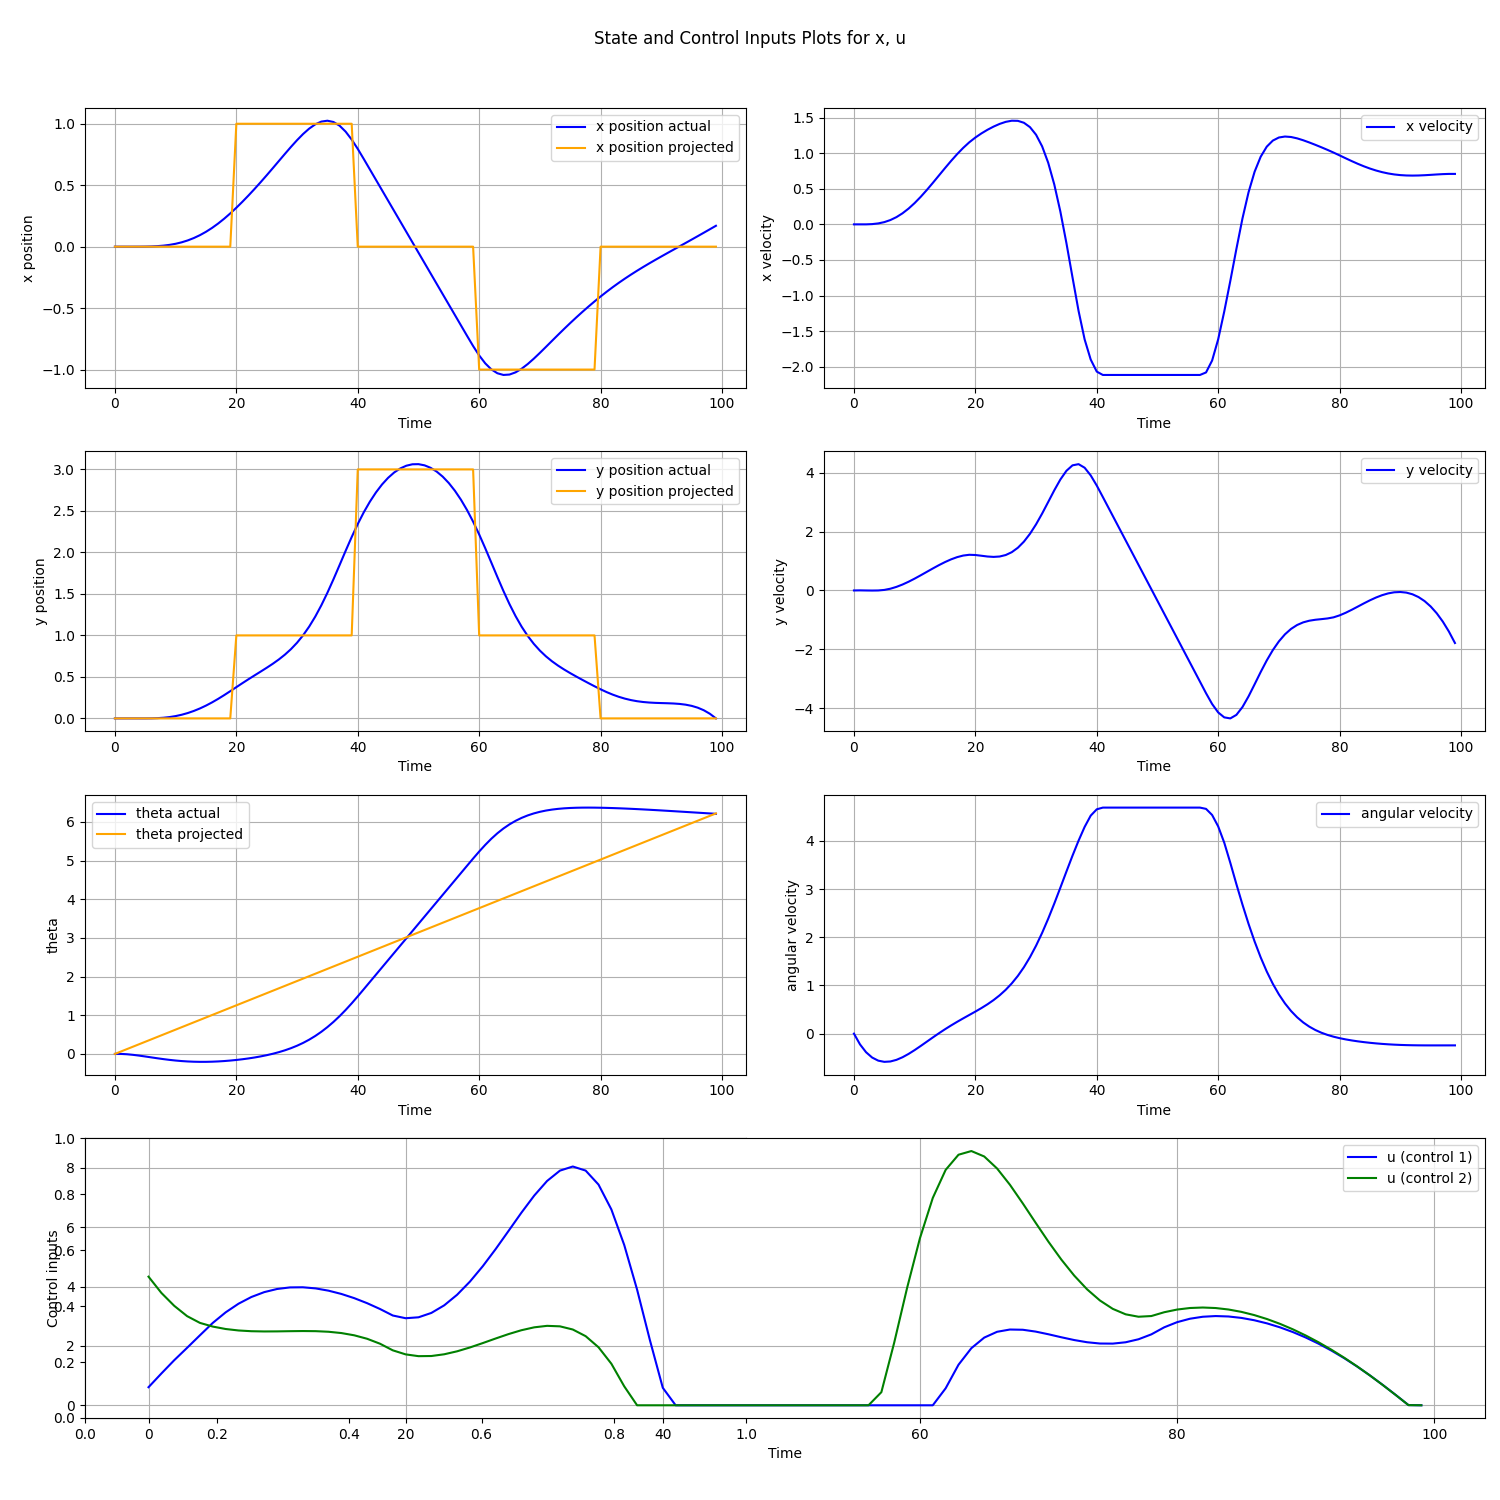

No such comm: ea93c12ce3114369b3d041405364f722
No such comm: 20fbd6ee5cf148eea424520d278d683b
No such comm: 20fbd6ee5cf148eea424520d278d683b
No such comm: 20fbd6ee5cf148eea424520d278d683b
No such comm: 20fbd6ee5cf148eea424520d278d683b
No such comm: bcf0f59090f049ec845fe1c3a4326847
No such comm: bcf0f59090f049ec845fe1c3a4326847
No such comm: bcf0f59090f049ec845fe1c3a4326847
No such comm: bcf0f59090f049ec845fe1c3a4326847
No such comm: 721d1d2ff38a40d9827d7fc14db2489b
No such comm: 721d1d2ff38a40d9827d7fc14db2489b
No such comm: 721d1d2ff38a40d9827d7fc14db2489b
No such comm: 721d1d2ff38a40d9827d7fc14db2489b
No such comm: f3cd904f913e466ebc9328a557c30579
No such comm: f3cd904f913e466ebc9328a557c30579
No such comm: f3cd904f913e466ebc9328a557c30579
No such comm: f3cd904f913e466ebc9328a557c30579
No such comm: d9b124f9d9f44cd5a235691b18627a78
No such comm: d9b124f9d9f44cd5a235691b18627a78
No such comm: d9b124f9d9f44cd5a235691b18627a78
No such comm: d9b124f9d9f44cd5a235691b18627a78
No such comm:

In [ ]:
def plot_x_u(x: np.ndarray, u: np.ndarray) -> None:
    """
    Plots the state and control trajectories of the quadrotor in a single figure.

    Parameters:
    ----------
    x : np.ndarray
        The state trajectory of the quadrotor. Shape: `(DIM_STATE, N)`.
    u : np.ndarray
        The control input trajectory. Shape: `(DIM_CONTROL, N)`.

    Raises:
    ------
    ValueError
        If the shapes of `x` or `u` do not match the expected dimensions.

    Returns:
    -------
    None
    """
    if x.shape[0] != quadrotor.DIM_STATE:
        raise ValueError(
            f"Input x must be of shape ({quadrotor.DIM_STATE}, N), but got shape {x.shape}")

    if u.shape[0] != quadrotor.DIM_CONTROL:
        raise ValueError(
            f"Input u must be of shape ({quadrotor.DIM_CONTROL}, N), but got shape {u.shape}")

    # Set the figure size
    x_figsize = 15
    y_figsize = 15

    # Create a time array based on the number of columns in x and u
    timex = np.arange(x.shape[1])
    timeu = np.arange(u.shape[1])

    # Compute the projected values for xyt
    xyt_projected = np.array([find_xk_yk_thetak(k=k) for k in timex])

    # Create a single figure with a 4-row, 2-column layout
    fig, axs = plt.subplots(4, 2, figsize=(x_figsize, y_figsize))
    fig.suptitle(f"State and Control Inputs Plots for x, u")

    # Plot x position
    axs[0, 0].plot(timex, x[0, :], label='x position actual', color='blue')
    axs[0, 0].plot(timex, xyt_projected[:, 0],
                   label='x position projected', color='orange')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('x position')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot x velocity
    axs[0, 1].plot(timex, x[1, :], label='x velocity', color='blue')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('x velocity')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot y position
    axs[1, 0].plot(timex, x[2, :], label='y position actual', color='blue')
    axs[1, 0].plot(timex, xyt_projected[:, 1],
                   label='y position projected', color='orange')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('y position')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot y velocity
    axs[1, 1].plot(timex, x[3, :], label='y velocity', color='blue')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('y velocity')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Plot theta
    axs[2, 0].plot(timex, x[4, :], label='theta actual', color='blue')
    axs[2, 0].plot(timex, xyt_projected[:, 2],
                   label='theta projected', color='orange')
    axs[2, 0].set_xlabel('Time')
    axs[2, 0].set_ylabel('theta')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    # Plot theta velocity
    axs[2, 1].plot(timex, x[5, :], label='angular velocity', color='blue')
    axs[2, 1].set_xlabel('Time')
    axs[2, 1].set_ylabel('angular velocity')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    # Plot control inputs (u) in the fourth row, spanning both columns
    axs[3, 0] = plt.subplot(4, 2, (7, 8))
    axs[3, 0].plot(timeu, u[0, :], label='u (control 1)', color='blue')
    axs[3, 0].plot(timeu, u[1, :], label='u (control 2)', color='green')
    axs[3, 0].set_xlabel('Time')
    axs[3, 0].set_ylabel('Control inputs')
    axs[3, 0].legend()
    axs[3, 0].grid(True)

    # Remove the unused axis in the fourth row
    fig.delaxes(axs[3, 1])

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def save_plot_x_u(x: np.ndarray, u: np.ndarray, problem: str = 'SQP') -> None:
    """
    Saves individual plots of state and control trajectories.

    Parameters:
    ----------
    x : np.ndarray
        The state trajectory of the quadrotor. Shape: `(DIM_STATE, N)`.
    u : np.ndarray
        The control input trajectory. Shape: `(DIM_CONTROL, N)`.
    problem : str, optional
        A label for the problem type to include in plot titles and filenames. Default is 'SQP'.

    Raises:
    ------
    ValueError
        If the shapes of `x` or `u` do not match the expected dimensions.

    Returns:
    -------
    None
    """
    if x.shape[0] != quadrotor.DIM_STATE:
        raise ValueError(
            f"Input x must be of shape ({quadrotor.DIM_STATE}, N), but got shape {x.shape}")

    if u.shape[0] != quadrotor.DIM_CONTROL:
        raise ValueError(
            f"Input u must be of shape ({quadrotor.DIM_CONTROL}, N), but got shape {u.shape}")

    # Create a time array based on the number of columns in x and u
    timex = np.arange(x.shape[1])
    timeu = np.arange(u.shape[1])

    # Compute the projected values for xyt
    xyt_projected = np.array([find_xk_yk_thetak(k=k) for k in timex])

    # Plot x position
    plt.figure()
    plt.plot(timex, x[0, :], label='x position actual', color='blue')
    plt.plot(timex, xyt_projected[:, 0],
             label='x position projected', color='orange')
    plt.xlabel('Time')
    plt.ylabel('x position')
    plt.legend()
    plt.grid(True)
    plt.title(f"x position - Problem: {problem}")
    plt.savefig(f"plots/X Position {problem}.png")
    plt.close()

    # Plot x velocity
    plt.figure()
    plt.plot(timex, x[1, :], label='x velocity', color='blue')
    plt.xlabel('Time')
    plt.ylabel('x velocity')
    plt.legend()
    plt.grid(True)
    plt.title(f"x velocity - Problem: {problem}")
    plt.savefig(f"plots/X Velocity {problem}.png")
    plt.close()

    # Plot y position
    plt.figure()
    plt.plot(timex, x[2, :], label='y position actual', color='blue')
    plt.plot(timex, xyt_projected[:, 1],
             label='y position projected', color='orange')
    plt.xlabel('Time')
    plt.ylabel('y position')
    plt.legend()
    plt.grid(True)
    plt.title(f"y position - Problem: {problem}")
    plt.savefig(f"plots/Y Position {problem}.png")
    plt.close()

    # Plot y velocity
    plt.figure()
    plt.plot(timex, x[3, :], label='y velocity', color='blue')
    plt.xlabel('Time')
    plt.ylabel('y velocity')
    plt.legend()
    plt.grid(True)
    plt.title(f"y velocity - Problem: {problem}")
    plt.savefig(f"plots/Y Velocity {problem}.png")
    plt.close()

    # Plot theta
    plt.figure()
    plt.plot(timex, x[4, :], label='theta actual', color='blue')
    plt.plot(timex, xyt_projected[:, 2],
             label='theta projected', color='orange')
    plt.xlabel('Time')
    plt.ylabel('theta')
    plt.legend()
    plt.grid(True)
    plt.title(f"Theta - Problem: {problem}")
    plt.savefig(f"plots/Theta {problem}.png")
    plt.close()

    # Plot theta velocity
    plt.figure()
    plt.plot(timex, x[5, :], label='angular velocity', color='blue')
    plt.xlabel('Time')
    plt.ylabel('angular velocity')
    plt.legend()
    plt.grid(True)
    plt.title(f"Angular velocity - Problem: {problem}")
    plt.savefig(f"plots/Angular Velocity {problem}.png")
    plt.close()

    # Plot control inputs
    plt.figure()
    plt.plot(timeu, u[0, :], label='u (control 1)', color='blue')
    plt.plot(timeu, u[1, :], label='u (control 2)', color='green')
    plt.xlabel('Time')
    plt.ylabel('Control inputs')
    plt.legend()
    plt.grid(True)
    plt.title(f"Control inputs - Problem: {problem}")
    plt.savefig(f"plots/Control Inputs {problem}.png")
    plt.close()


plot_x_u(x=x, u=u)
save_plot_x_u(x=x, u=u)

## Soultion : Part 2 - Model predictive control (MPC) (50 points)

Developing a controller for MPC is fairly simple. The only thing needed is to call the ```filter_line_search()``` function at every time step, giving the current position and time step of the quadrotor as an input and recomputing the optimal control problem for a finite set of time steps. The size of this set is chosen based on two factors - 
    1. Speed of solving : The solver needs to find the optimal control to push the current state into the next almost instantaneously (In our case, under 0.04s)
    2. Capture sufficient amount of long term trajectory information : The solver needs to ensure that enough of the trajectory has been optimized over to ensure that the computed optimal control will be feasible enough to reach the future goal. 

Balancing these two factors is tricky, so, for the current chosen trajectory, the smallest number of time steps for the MPC controller is 50. Thus, for every time step, we shall optimize the trajectory for the next 50 time steps and provide the control signal to the system. This shall push the system into the next state, upon which we shall again optimize the trajectory and provide a new optimal control. We shall keep repeating this until the entire chosen time horizon has been followed by the quadrotor. 

Additionally, this controller will be provided to the inbuilt simulator, setting ```disturbance=True```. As we are resolving the optimal control problem at every time step, it should be able to handle disturbances in the control signal and ensure that the drone maintains the desired trajectory. Based on this logic, the below code has been written.

In [46]:
import numpy as np
import gc


def controller(x_init: np.ndarray, k_init: int, verbose: bool = True) -> np.ndarray:
    """
    Quadrotor controller using filter line search optimization for trajectory tracking.

    Parameters:
    ----------
    x_init : np.ndarray
        Initial state of the quadrotor. Shape: `(DIM_STATE,)`.
    k_init : int
        Initial time step index for trajectory optimization.
    verbose : bool, optional
        If `True`, prints detailed logs during optimization. Default is `True`.

    Returns:
    -------
    np.ndarray
        The control input for the first time step after optimization. Shape: `(DIM_CONTROL,)`.

    Raises:
    ------
    ValueError
        If the optimization fails due to infeasibility or numerical issues.

    Notes:
    ------
    - This function initializes the guess for the state and control trajectories (`y_guess`)
      and optimizes the trajectory over a finite prediction horizon (`TIME_STEPS`).
    - If optimization is successful, it computes the control input and logs key results.
    - If optimization fails, an error message is printed, and garbage collection is performed.
    """
    # Define the prediction horizon
    TIME_STEPS = 50

    # Initialize guess for state and control trajectories
    y_guess = np.zeros(
        (quadrotor.DIM_CONTROL + quadrotor.DIM_STATE) * TIME_STEPS, dtype=np.float64)
    # Set the initial state in the guess
    y_guess[:quadrotor.DIM_STATE] = x_init

    try:
        # Solve for the optimal trajectory using filter line search
        x, u = filter_line_search(
            x_init=x_init,
            y_guess=y_guess,
            Q_diag=np.array([31.25, 0.03125, 31.25, 0.03125, 3.125,
                            0.03125], dtype=np.float64),  # State weighting
            # Control weighting
            R_diag=np.array([0.75, 0.75], dtype=np.float64),
            N=TIME_STEPS,
            verbose=False,
            rho=0.5,
            tol=1e-4,
            k_init=k_init
        )

        # Log optimization results if verbose is enabled
        if verbose:
            next_state = quadrotor.next_state(
                x[:, 0].flatten(), u[:, 0].flatten())
            print(
                f"For k = {k_init}\n"
                f"    x_init  = {x[:, 0].flatten()}\n"
                f"    u = {u[:, 0].flatten()}\n"
                f"    Next State = {next_state}"
            )

    except ValueError as e:
        # Handle optimization failure
        print(f"Optimization failed at time {k_init * quadrotor.DT}: {e}")

    # Perform garbage collection
    gc.collect()

    # Return the control input for the first time step
    return u[:, 0].flatten()


# Simulation parameters
horizon_length = 300  # Total simulation horizon length

# Simulate the quadrotor's trajectory
t, state, u = quadrotor.simulate(
    x_init,  # Initial state
    controller,  # Controller function
    horizon_length,  # Simulation length
    disturbance=True  # Enable disturbances
)

# Animate the quadrotor's trajectory
quadrotor.animate_robot(state, u)

For k = 0
    x_init  = [ 1.09798526e-20 -2.06721121e-15 -7.26488567e-20  3.08039831e-11
  9.67333701e-17  5.14783831e-15]
   u = [0.18161502 4.82049298]
   Next State = [-8.26774685e-17 -2.10592087e-15  1.23215925e-12  7.76864016e-03
  3.02646902e-16 -2.78332678e-01]
For k = 1
    x_init  = [ 0.00000000e+00 -6.83509247e-01  1.58260320e-03 -4.44727789e+00
  5.11604786e-08  4.99523502e-01]
   u = [10.66055221 10.17089806]
   Next State = [-0.02734037 -0.68350933 -0.17630851 -3.17316187  0.01998099  0.52890275]
For k = 2
    x_init  = [-0.02640568 -0.66014193  0.36620794 -4.82112521  0.01929082  0.51467989]
   u = [10.93797241 11.12547316]
   Next State = [-0.05281135 -0.69418958  0.17336293 -3.44877798  0.03987802  0.50342985]
For k = 3
    x_init  = [-0.06263925 -0.82337634 -0.3064168   0.06099552  0.04730029  0.59575616]
   u = [ 1.19273429 11.1160756 ]
   Next State = [-9.55743012e-02 -8.69935800e-01 -3.03976983e-01  6.52198966e-01
  7.11305388e-02  3.55676916e-04]
For k = 4
    x_in

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABKQttZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
ETVliIQAN//+9vD+BTY7mNCXEc3onTMfvxW4ujQ3vc4AAAMAAAMAAAMAADSY0H4zd2rDhiAAAAMA
JgAGCANgAzAEdwBJhifrPwALwRFkBJwPzJUmFGT2qHXo4m6RCitIlhRYet3pioe7PtHMnO4JkntJ
ujXVK9mpvpov1Dq5CrLp26+E/qiy2XJ1DXbFQFIeD6dj4d/Ycg4MlRjSj5F/jO4dneZbKchBkxER
1+dwaLseoQTUOIHe+AjMd/01j3lkHunyumHGATF5QfuGMNEhmAiiUAYOIeHxFiIgg2yx/sREsJlD
kHggnz8ibjDHy6sod15ejTD7nM3nSKn356x7NU+rLjiy+TGV7zlKZBPivMIavE++a9A0lqsJYdgr
ySjKMHT/BXnDAgmDXfO64jpiyGPFAqtkFWJ5TEQleZ1J5ApIiAbrmpifDenz7+L/Amzw77yl2Tw8
dV/vzdPNgHyNMPd7Qeurp1KvON9Kpiiq9WLcXgAu6rO4VJF3rAEt8s69kj217dTvtZESV+cTFtXm
3MWiO6d6NaNes2JxyIga8j/MW3CqBIXjhkLWvdScKZvg8MVaqrvYXuPHtXdox+2jtMl6rE9m/6s+
6Cy5TIeNjaXXn1STQyWNTn8r0KGY5XUU8YWj4rZIaUkBqvdT8HuUUf+o5XJ26+3LKiBErocn6j49
qq8oSXOlEJOrVByQ/AJBrvhIWmp7Arh1AuEuWsSZb82qwUX4YpLA+jhMqj8m793/30LpXeFCUvZ2
UCe1W6p2YBPju3XCRbv1SUWh+PCzX/y/JOTn5daKAGqplfjh5srEeY/c4vSTRR95J8M5n4/TGcAx
LQ3PrLHc2GMPnZEJfxoC+wBYhBAypi/Fy9xMI1ucvHymIu5d422tynfquHUyrPs+EoGJWAKSh7sA
/1MVNHQEZn8PVx0E7zdACzSSpOOGTWhaF57lTZmwv25AAm1RWpQZQNAjDBwssbGzn7T9AUYvB5TR
OC2Y81b4lVRo85K9ALdVT88zTm3NQJtghKkRdRSpqhUtIrjCZKMykOlm2t9EO0rQF5ZuCfH/lz+/
UwWvmDPTn9cTK5z3Vxl7LtLEbhh5Vfx71ieysrD8L/9IQmf+q2zFJh7Sh+8YpRuqdP1EIbAeOEuG
IyXAZ8dExE3ggS3C04yJjAgtHFPfwoCk4e5VyD1+YVxVKaQ+yeMF6HGK7M7BdG0++ViQSUecZkcy
q1tCyReJ2zQBZtiL+Q3loxtWdewSaQ+NnVN7fG8qziVfQ55Fst86EHRbfp6enX6l609SVLqc8hcx
f/fCQwUA3xUgn9ALzX/KIqIs204slWYN4Bk3i0PMdv4mAPQ3kYPhLZ2GJFrqmMsOmKKc+fGkIXiC
sZIoKF5Reli6qIvktB/sjAAAAwAAAwJFsjA4IkNwgAA9uSydKQoAAhPDEJrYbP3KymRGga1Uuohm
xKhZH2Yn5lK0WzScL2WGjTB/ekTdy0Qj6v0Vxsxl9IRSLhPGYqw4lo0h9Gy1L577forFFKRxihz6
kzx6/BLo4iiyYv2hjdbN8Wig5xtYr1wGNx0Kh8FGJplZtY3rNX1siz7GbExK2ilgZoY3IvSqyG+r
p3NIYBygdQBY9goi6QL9EqkIaGSrTtqhKxkTDBLEtNZR2edrWma7E3g+yP981nxNykV+txjd6Too
CDpvi0xCz+sDeSe1XSL/PIvTOTLmU7nvU5qRF6PzkdSR7sOzZ8JWAjLQpaDr7YQmEjZDKjOhnFd+
f/ol9l83p1eahAT8NSfsJq96apkvXOJu7gXQqFq62XJvZaAWsl3t/bu5aEwIeiej4wWI1KO9JYIM
1WbwSg1HcnUEXfmRykf8DfuYCvfl00F8IBrJwwgTiHUBKUB57n0JSis0VEe2Bqos3/WPU51f1plK
60tIAaYYQAAAAwAAAwNmKAAhgDZH3lKk6WELRF0zPVncliFPwAKIbRVzKEM39EQ3/zGwoxAQVCVN
VMbiNdyDQ7qaZTHf++gnFiKLVwq8OeWhs+pljDR7GapvndVDjuLqruO84748BmhLrJ0bHG/FgMwW
LFPfbCeHC0rl4dlIQ7szhoopHQPY9vf80OLVwDD06pb9kENjiSnyjkpoOeQaoiDz1OqNn2L+Anwr
vjXGH7FS55XgN5DoM4DbJ+12rP32XrQYMkFdaqWeJtjtLIQA9ALUJK9SfMA1SKp8L97DZx/IhJ3c
3aV/uAIdYveoepoo1oVTwG8o2NVzrpt+uToLiAr1LF6A8f89x64uL04NVVWZcrTskVA0HU6FSpub
7CIVzW2fffo6Hrs6+64ahRqyYpysBqVFCboH/vOGHlR4JloIXbp+MsDeBrgoAdu5aa8PX65LpdQ0
UXKJRsYl8NB/g4JOLYaIXmyDJgajRBV4w74XSizoy4Kpd2v/znwONjqvok+kEsSfgvnpUu+Mk9Y9
ASJcyg9X7zScRtGl5SIYzyHvbNCQPq+joatA9/Na9ZSp/WAylYavlWzShflHUKY4M4OWQr31SAdp
gWz0GB/3miaPZ+vxjlv8uSpiN0DsznVf//9xEjWT/UJr/4NAgpcpx4yaXOJ/sksyEvKHnWLEcJ+I
sxYA41o59UUTKO9h1DsFBVemOMKkWkok3KwAAAMAAAMArjGe3ioC7M1MTOM3SgjCt/T06zB8sqO+
vx36ixjdbPkYnNvxvQMgCSp7SsE2BxMNnGJzqz9nK1f+LWw2jCuGVCNi2bS8KPXoUif23Zr6SUFx
R/lRwvTeOlrDBx8dwn7nlVcnXYPCkGySuDjYWdkfIkxwV1692VqXw/Eb4MUX+LIwKDcfeOslmNAs
T0VkqHhqJdg+0VyDkWNd60jCwr/MnlC7338qnMtT8uRJpsRkHHEeEjgOGy9zyodlp1yWKk7bl1uu
X2wBflkAOK/TmuTlrTd8i

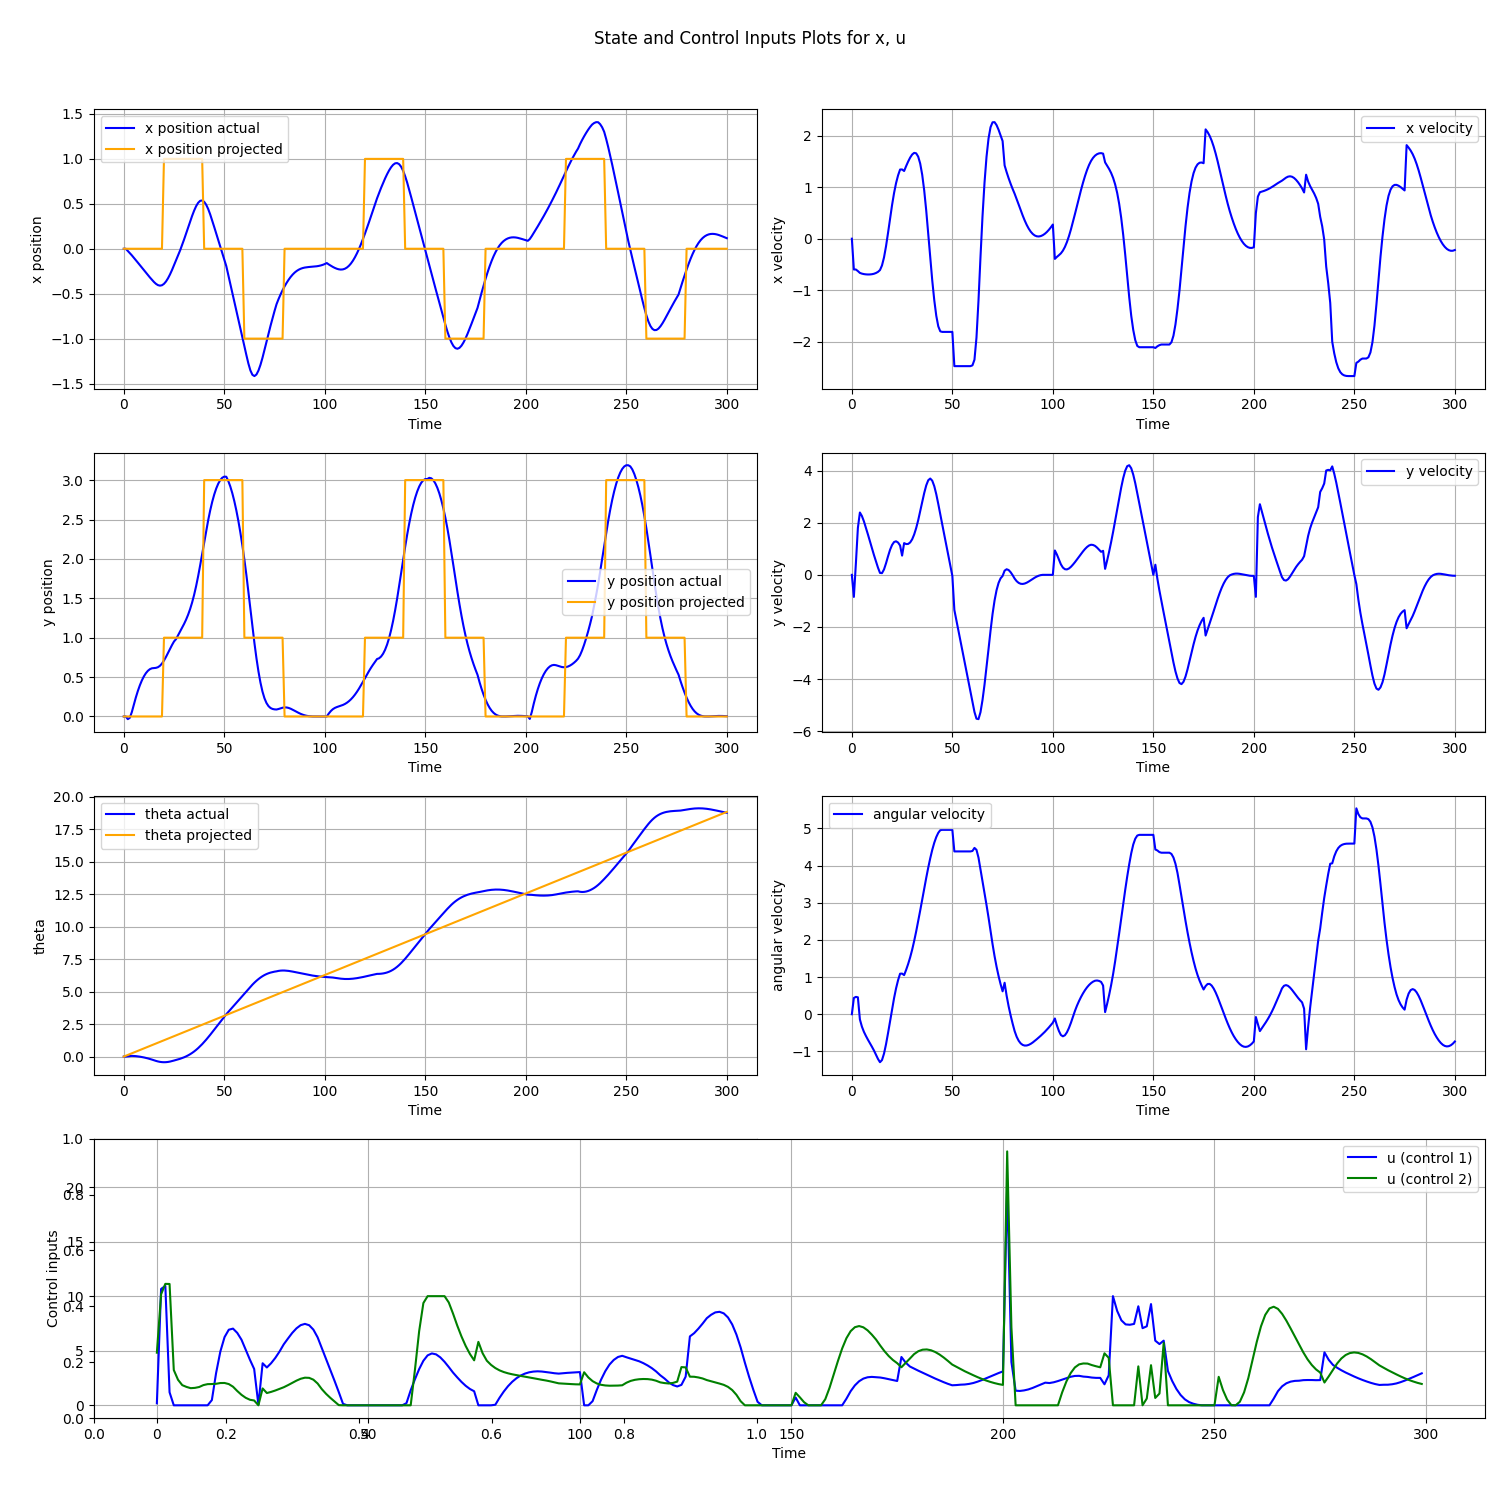

In [47]:
save_plot_x_u(x=state, u=u, problem='MPC')
plot_x_u(x=state, u=u)